**Imports**

In [1]:
# Standard imports
import cv2
import numpy as np;
import os
import pandas as pd

**Blob detector to detect skyrmions**

In [2]:
# Blob detecotor parameters
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 10
params.maxThreshold = 200

# Filter by Area.
params.filterByArea = True
params.minArea = 10

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87
    
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

# Different versions
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3:
    detector = cv2.SimpleBlobDetector(params)
else: 
    detector = cv2.SimpleBlobDetector_create(params)

**Detect skyrmions**

In [3]:
directory = 'Rec_EDGE_300K_1L_50MA.out'

frames = None

no_skyrmions = 15

for filename in os.listdir(directory):
    # if png
    if filename.endswith(".png"):
        coordinates = None
        # Read image
        image = os.path.join(directory, filename)
        im = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

        # Detect
        detector.empty()
        keypoints = detector.detect(im)
        
#         # Draw detected blobs as red circles.
#         # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
#         im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#         # Show keypoints
#         cv2.imshow("Keypoints", im_with_keypoints)
#         cv2.waitKey(0)
        
        for p in keypoints:
            coordinates = np.append(coordinates, [p.pt[0], p.pt[1]]) if coordinates is not None else [p.pt[0], p.pt[1]]
            
        # if skyrmions arenot detected, then they are at the border of the image
        # impute putting them in the centre on the left side of the image
        while (len(coordinates) < 2 * no_skyrmions):
            coordinates = np.append(coordinates, [0, im.shape[:2][0] / 2]) if coordinates is not None else [0, im.shape[:2][0] / 2]
                               
        frames = np.append(frames, coordinates) if frames is not None else [coordinates]

frames = frames.reshape(-1, 2 * no_skyrmions)

**Save data to file**

In [4]:
# Save frames to file
with open('frames.txt', 'w') as f:
    for frame in frames:
        for i in range(0, len(frame), 2):
            f.write('(' + str(frame[i]) + ', ' + str(frame[i+1]) + '), ')
        f.write('\n\n')

## One image input

**Make data samples**

In [5]:
# Samples are (frame, next_frame)

X = frames[:-1]
y = frames[1:]

**Split data for training and testing**

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [7]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (639, 30)
y_train shape: (639, 30)
X_test shape: (160, 30)
y_test shape: (160, 30)


**Hyperparameters**

In [8]:
activation = 'relu'

optimizer = 'NAdam'
loss = 'mae'
metrics = ['accuracy']
training_epochs = 100
batch_size = 128

n_input = 2 * no_skyrmions
n_hidden_1 = 500
n_hidden_2 = 300
n_hidden_3 = 100
n_output = 2 * no_skyrmions

**Build Neural Network**

In [9]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense

# Neural network
model = Sequential()
model.add(Dense(n_hidden_1, input_dim=n_input, activation=activation))
model.add(Dense(n_hidden_2, activation=activation))
model.add(Dense(n_hidden_3, activation=activation))
model.add(Dense(n_output))

Using TensorFlow backend.


In [10]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [11]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=training_epochs, batch_size=batch_size)

Train on 639 samples, validate on 160 samples
Epoch 1/100
639/639 [==============================] - 0s 265us/step - loss: 227.4768 - accuracy: 0.0548 - val_loss: 152.5622 - val_accuracy: 0.0625
Epoch 2/100
639/639 [==============================] - 0s 34us/step - loss: 145.4903 - accuracy: 0.0751 - val_loss: 119.1107 - val_accuracy: 0.0500
Epoch 3/100
639/639 [==============================] - 0s 31us/step - loss: 121.1648 - accuracy: 0.0845 - val_loss: 104.2787 - val_accuracy: 0.0812
Epoch 4/100
639/639 [==============================] - 0s 28us/step - loss: 113.2397 - accuracy: 0.0814 - val_loss: 103.4725 - val_accuracy: 0.0750
Epoch 5/100
639/639 [==============================] - 0s 28us/step - loss: 108.5447 - accuracy: 0.0814 - val_loss: 104.9759 - val_accuracy: 0.0812
Epoch 6/100
639/639 [==============================] - 0s 27us/step - loss: 105.8969 - accuracy: 0.0908 - val_loss: 97.9941 - val_accuracy: 0.0812
Epoch 7/100
639/639 [==============================] - 0s 28us/ste

In [12]:
prediction = model.predict(X_test)
print(y_test[0])
print(prediction[0])

[718.36688232 181.54312134 750.88781738 167.82029724 822.49157715
 115.64051819 834.37548828  72.7306366  793.40539551 176.15600586
 907.43200684  91.83383179 874.44042969  88.77855682 956.53039551
  88.87418365 838.09191895 157.66296387 641.89154053 149.71517944
 784.02624512 128.50732422 982.84967041  57.9220047   28.82333374
  43.27625656 719.50946045  76.93851471   0.         100.        ]
[664.5878   153.63202  681.1437   119.519424 631.45264  127.537315
 674.75885  123.70401  803.7171   110.11667  746.16626   69.0013
 805.9337    70.32828  770.01886   80.879135 829.79803   76.97737
 756.9094    70.85954  737.2682    72.0352   777.6817    72.96657
 726.79956   74.834854 792.2448   131.6845   756.0156    79.742645]


**Predict of test data**

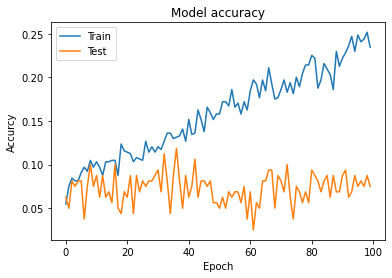

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accurcy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

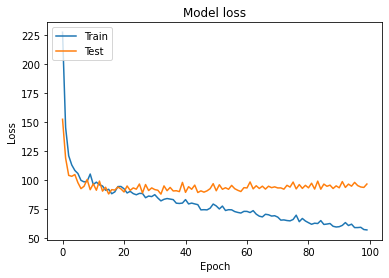

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## Two imges input

In [15]:
# Samples are ((frame, frame), next_frame)

X = None

for i in range(len(frames) - 2):
    X = np.append(X, np.append(frames[i], frames[i+1])) if X is not None else np.append(frames[i], frames[i+1])
X = X.reshape(-1, 4 * no_skyrmions)
y = frames[2:]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [17]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (638, 60)
y_train shape: (638, 30)
X_test shape: (160, 60)
y_test shape: (160, 30)


In [18]:
activation = 'relu'

optimizer = 'NAdam'
loss = 'mae'
metrics = ['accuracy']
training_epochs = 100
batch_size = 128

n_input = 4 * no_skyrmions
n_hidden_1 = 500
n_hidden_2 = 300
n_hidden_3 = 100
n_output = 2 * no_skyrmions

In [19]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense

# Neural network
model = Sequential()
model.add(Dense(n_hidden_1, input_dim=n_input, activation=activation))
model.add(Dense(n_hidden_2, activation=activation))
model.add(Dense(n_hidden_3, activation=activation))
model.add(Dense(n_output))

In [20]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [21]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=training_epochs, batch_size=batch_size)

Train on 638 samples, validate on 160 samples
Epoch 1/100
638/638 [==============================] - 0s 206us/step - loss: 222.7671 - accuracy: 0.0737 - val_loss: 161.9616 - val_accuracy: 0.0562
Epoch 2/100
638/638 [==============================] - 0s 33us/step - loss: 152.1924 - accuracy: 0.0846 - val_loss: 125.4096 - val_accuracy: 0.0500
Epoch 3/100
638/638 [==============================] - 0s 28us/step - loss: 121.8949 - accuracy: 0.0784 - val_loss: 113.8358 - val_accuracy: 0.0437
Epoch 4/100
638/638 [==============================] - 0s 28us/step - loss: 116.3672 - accuracy: 0.0925 - val_loss: 106.8757 - val_accuracy: 0.0625
Epoch 5/100
638/638 [==============================] - 0s 30us/step - loss: 112.7765 - accuracy: 0.0893 - val_loss: 100.1071 - val_accuracy: 0.1063
Epoch 6/100
638/638 [==============================] - 0s 30us/step - loss: 102.8446 - accuracy: 0.0893 - val_loss: 102.1962 - val_accuracy: 0.0625
Epoch 7/100
638/638 [==============================] - 0s 34us/st

In [22]:
prediction = model.predict(X_test)
print(y_test[0])
print(prediction[0])

[718.36688232 181.54312134 750.88781738 167.82029724 822.49157715
 115.64051819 834.37548828  72.7306366  793.40539551 176.15600586
 907.43200684  91.83383179 874.44042969  88.77855682 956.53039551
  88.87418365 838.09191895 157.66296387 641.89154053 149.71517944
 784.02624512 128.50732422 982.84967041  57.9220047   28.82333374
  43.27625656 719.50946045  76.93851471   0.         100.        ]
[615.1973   157.9789   610.94385  115.49883  691.0693   147.79192
 663.8217   122.003334 731.98364  100.21932  684.34845   92.90955
 631.53723  100.867256 727.06775   67.88844  706.6729    74.79453
 752.6026    84.831024 647.36053   94.66811  731.9088   107.00973
 690.2951   110.30579  649.9582    76.2412   757.60345   75.26033 ]


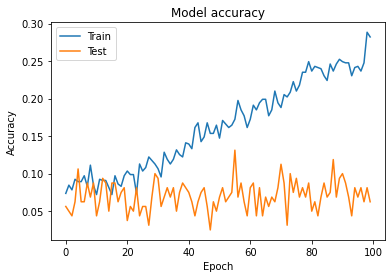

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

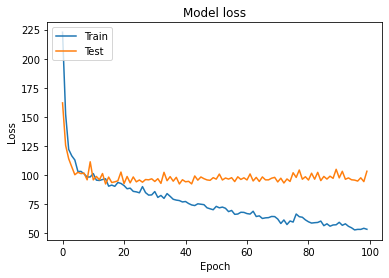

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## Preprocess data differently (as entire image)

In [25]:
def resize_keep_ratio(img, scale_percent):
    
    scale_percent = scale_percent # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    return resized

In [26]:
directory = 'Rec_EDGE_300K_1L_50MA.out'

frames = None

for filename in os.listdir(directory):
    # if png
    if filename.endswith(".png"):
        # Read image
        image = os.path.join(directory, filename)
        im = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

        im = resize_keep_ratio(im, 20)
        ret, im = cv2.threshold(im, 127,255, cv2.THRESH_BINARY)
        im = im.flatten()
        
        frames = np.append(frames, [im], axis=0) if frames is not None else [im]
        
frames = frames / 255.0

**Make data samples**

In [27]:
# Samples are (frame, next_frame)

X = frames[:-1]
y = frames[1:]

**Split data for training and testing**

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [29]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (639, 8000)
y_train shape: (639, 8000)
X_test shape: (160, 8000)
y_test shape: (160, 8000)


**Hyperparameters**

In [30]:
optimizer = 'adam'
loss = 'mae'
metrics = ['binary_accuracy']
training_epochs = 25
batch_size = 64

n_input = X_train.shape[1]
n_output = y_train.shape[1]

**Build Neural Network**

In [31]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense

# Neural network
model = Sequential()
model.add(Dense(500, input_dim=n_input, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(n_output, activation='tanh'))

In [32]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [33]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=training_epochs, batch_size=batch_size)

Train on 639 samples, validate on 160 samples
Epoch 1/25
639/639 [==============================] - 1s 2ms/step - loss: 0.1901 - binary_accuracy: 0.8323 - val_loss: 0.0113 - val_binary_accuracy: 0.9887
Epoch 2/25
639/639 [==============================] - 1s 2ms/step - loss: 0.0113 - binary_accuracy: 0.9887 - val_loss: 0.0113 - val_binary_accuracy: 0.9887
Epoch 3/25
639/639 [==============================] - 1s 1ms/step - loss: 0.0113 - binary_accuracy: 0.9887 - val_loss: 0.0113 - val_binary_accuracy: 0.9887
Epoch 4/25
639/639 [==============================] - 1s 1ms/step - loss: 0.0113 - binary_accuracy: 0.9887 - val_loss: 0.0113 - val_binary_accuracy: 0.9887
Epoch 5/25
639/639 [==============================] - 1s 1ms/step - loss: 0.0113 - binary_accuracy: 0.9887 - val_loss: 0.0113 - val_binary_accuracy: 0.9887
Epoch 6/25
639/639 [==============================] - 1s 2ms/step - loss: 0.0113 - binary_accuracy: 0.9887 - val_loss: 0.0113 - val_binary_accuracy: 0.9887
Epoch 7/25
639/639

In [34]:
prediction = model.predict(X_test)

**Predict of test data**

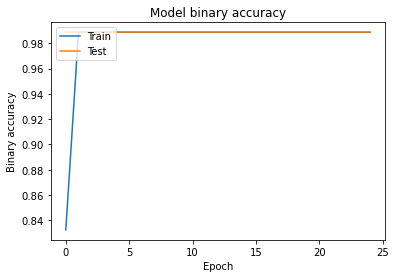

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model binary accuracy')
plt.ylabel('Binary accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

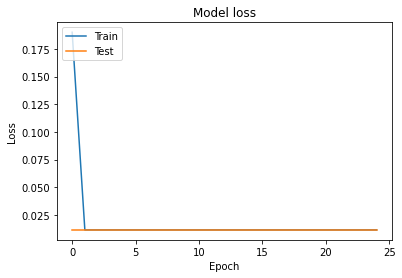

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()